In [1]:
import os
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import skimage.filters as filt
import skimage.measure as meas
import skimage.segmentation as segm
import skimage.morphology as morph
import skimage.util as util

from sklearn.cluster import KMeans, DBSCAN

data_path = "/media/becode/3D_House/concrete/Positive"


In [2]:
files = os.listdir(data_path)[:20]
load_image = lambda file: plt.imread(join(data_path, file))
rgb_to_grey = lambda im: np.dot(im[..., :3], [.21, .72, .07])

<ipython-input-8-6994d1c94da2>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours = np.array(list(filter(lambda f: len(f) >= min_samples,


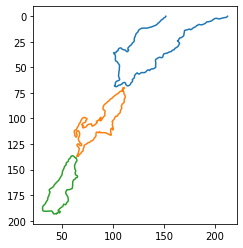

In [8]:
image = rgb_to_grey(load_image(files[11]))
#plt.imshow(image)

min_samples = 100
contours = np.array(list(filter(lambda f: len(f) >= min_samples,
                                meas.find_contours(image, 120))))
for contour in contours: plt.plot(*list(zip(*np.flip(contour))))
    
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

plt.axis('scaled')
plt.show()

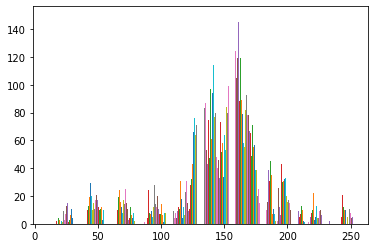

In [6]:
image = rgb_to_grey(load_image(files[7]))
plt.hist(image)
plt.show()

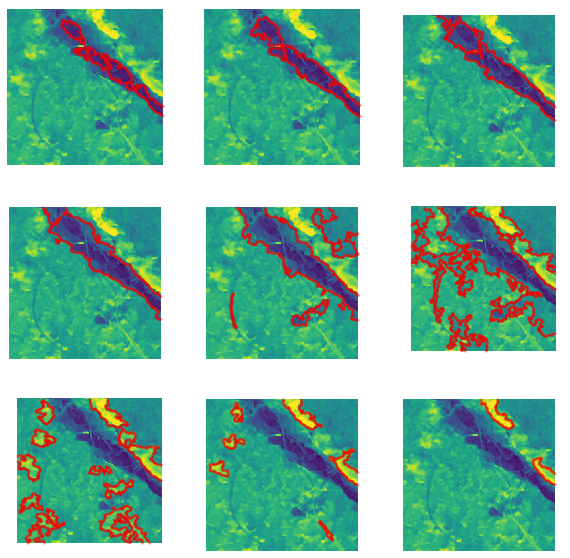

In [8]:
image = rgb_to_grey(load_image(files[7]))

fig, ax = plt.subplots(3,3, figsize=(10,10))
ax = ax.flatten(); [ax.set_axis_off() for ax in ax]

for idx, level in enumerate([50,70,90,110,130,150,170,190,210]):
    min_samples = 100
    contours = np.array(list(filter(lambda f: len(f) >= min_samples,
                                    meas.find_contours(image, level))))
    if len(contours) ==0: continue
    
    ax[idx].imshow(image)
    ax[idx].scatter(
        *list(zip(*np.flip(np.concatenate(contours)))),
        c="r",s=3, alpha=.2)

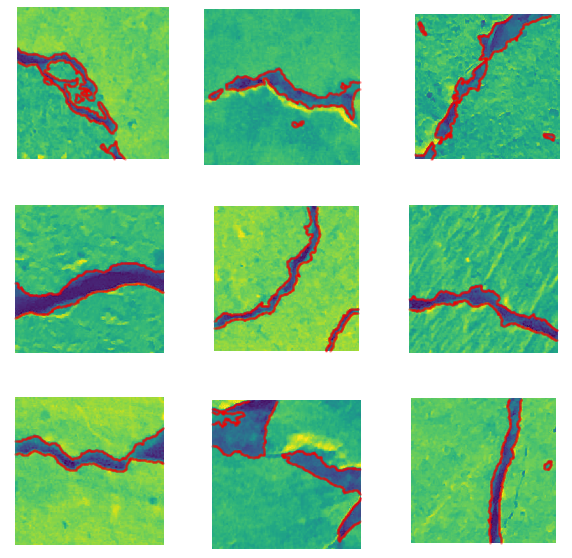

In [11]:
optimal_level = lambda im: np.mean(np.array_split(np.sort(im.flatten()), 2)[0])

fig, ax = plt.subplots(3,3, figsize=(10,10))
ax = ax.flatten(); [ax.set_axis_off() for ax in ax]

min_samples = 50
offset = -10
for idx, file in enumerate(os.listdir(data_path)[9:18]):
    image = rgb_to_grey(load_image(join(data_path, file)))
    level = optimal_level(image) +offset
    contours = np.array(meas.find_contours(image, level))
    contours = list(filter(lambda f: len(f) > min_samples, contours))
    
    ax[idx].imshow(image)
    ax[idx].scatter(
        *list(zip(*np.flip(np.concatenate(contours)))),
        c="r",s=3, alpha=.2)

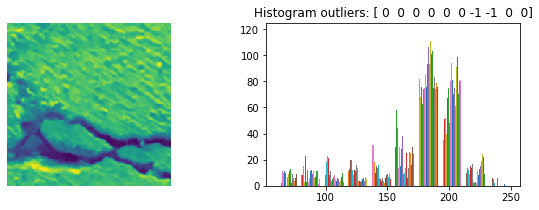

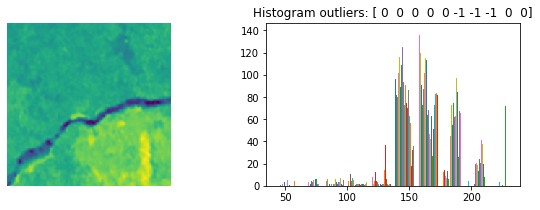

In [13]:
for idx, file in enumerate(files):
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    image = filt.gaussian(rgb_to_grey(load_image(file)))
    ax[0].imshow(image)
    ax[0].set_axis_off()
    hist = np.array(ax[1].hist(image)[0])
    mean_hist = np.apply_along_axis(lambda a: np.mean(a), 0, hist)
    plt.title("Histogram outliers: " +str(DBSCAN(eps=np.mean(mean_hist)).fit_predict(mean_hist.reshape(-1,1))))
    plt.show()
    
    if idx == 1: break

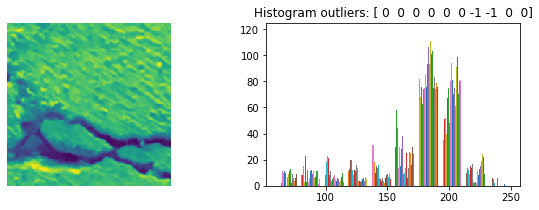

In [14]:
for idx, file in enumerate(files):
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    image = filt.gaussian(rgb_to_grey(load_image(file)))
    ax[0].imshow(image)
    ax[0].set_axis_off()
    hist = np.array(ax[1].hist(image)[0])
    mean_hist = np.apply_along_axis(lambda a: np.mean(a), 0, hist)
    dbscan = DBSCAN(eps=np.mean(mean_hist)).fit_predict(mean_hist.reshape(-1,1))
    #print(hist[:, np.nonzero(list(dbscan))[0]])
    
    plt.title("Histogram outliers: " +str(dbscan))
    plt.show()
    
    if idx == 0: break

# combine skeletonize with mask_crack

In [3]:
min_max = lambda arr: (arr.min(), arr.max())
def mask_crack(im, plot=False, save:str=None, return_mask=False):
    """
    Turn input image into a mask that maps crack in concrete
    Type im can be np. or path (str)
    Path can be passed to save generated plot
    """
    
    if type(im) == str: im = plt.imread(im)
    image = rgb_to_grey(im)
    kmeans = KMeans(4).fit_predict(image.flatten().reshape(-1,1)).reshape(image.shape)
    
    clst_values = []
    for i, clst in enumerate(np.unique(kmeans)):
        arr = np.zeros(kmeans.shape)
        arr[kmeans==clst]=1
        clst_values.append(arr)
         
    kmeans = kmeans.flatten()
    main_clst = np.array(sorted(zip(*np.unique(kmeans, return_counts=True)), key=lambda i:i[1]))[-2:,0]

    crack_mask = np.ones(image.shape)
    for cluster_idxs in main_clst: crack_mask -= clst_values[cluster_idxs]

    crack_xy = np.array(list(zip(*crack_mask.nonzero())))
    crack_dbscan = DBSCAN(eps=1).fit(crack_xy)

    main_clst = sorted(zip(*np.unique(crack_dbscan.labels_, return_counts=True)), key=lambda i:i[1])[-1][0]

    dbscan_xy = np.array(list(map(lambda x: x[0], 
        filter(lambda x: x[1]==main_clst, 
               zip(crack_xy, crack_dbscan.labels_)))))

    result = np.zeros(image.shape)
    for idxy in dbscan_xy: result[idxy[0], idxy[1]]=1
        
    bounds_x = min_max(np.array(list(zip(*np.nonzero(result))))[:,1])
    bounds_y = min_max(np.array(list(zip(*np.nonzero(result))))[:,0])
    surface = result.sum().astype(int)

    plt.imshow(result)
    plt.plot(
        [bounds_x[0],bounds_x[1],bounds_x[1],bounds_x[0],bounds_x[0]],
        [bounds_y[0],bounds_y[0],bounds_y[1],bounds_y[1],bounds_y[0]],
        c="r", linewidth=4)
    plt.text(75, 110, f"{round(surface/100, 1)} cm²", color="w", fontsize=16)
    
    if save: plt.savefig(save)
    if not plot: plt.close()
    
    if return_mask: return result

In [58]:
idx = 0

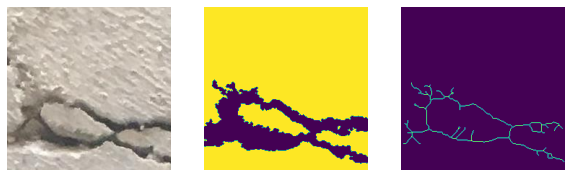

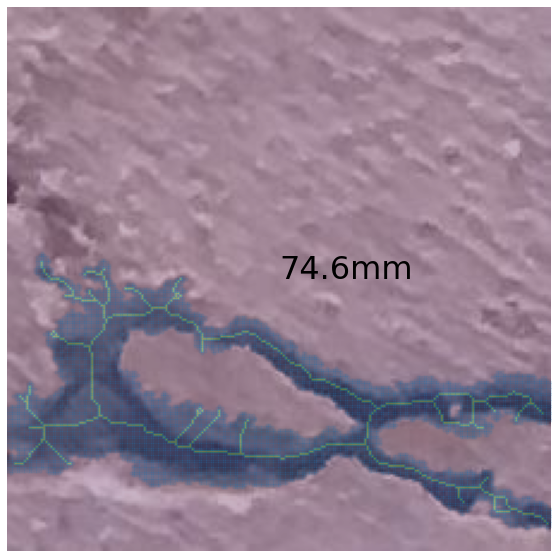

In [59]:
image = plt.imread(join(data_path, files[idx]))
mask = mask_crack(image, return_mask=True)
data = np.array(list(zip(*np.nonzero(mask)))).T
skeleton = morph.skeletonize(mask)
fig, ax = plt.subplots(1,3,figsize=(10,3))
[ax.set_axis_off() for ax in ax]

ax[0].imshow(image)
ax[1].imshow(util.invert(mask))
ax[2].imshow(skeleton)

plt.figure(figsize=(10,10))
plt.scatter(x=data[1,:], y=data[0,:], s=10, alpha=.1)
plt.imshow(image)

plt.imshow(skeleton, alpha=.3)
plt.gca().text(.5,.5, fontsize=32, s=f"{skeleton.sum()/10}mm", transform = plt.gca().transAxes)
plt.gca().set_axis_off()

idx += 1
if idx >=20: idx =0

In [ ]:
optimal_level = lambda im: np.mean(np.array_split(np.sort(im.flatten()), 2)[0])
file = os.listdir(data_path)[0]
image = rgb_to_grey(load_image(join(data_path, file)))
mask = mask_crack(image, return_mask=True)
min_samples, offset = 50, -10
level = optimal_level(image) +offset
contours = np.array(mm.find_contours(image, level))
contours = list(filter(lambda f: len(f) > min_samples, contours))

plt.scatter(*list(zip(*np.flip(np.concatenate(contours)))), c="r", s=3, alpha=.2)